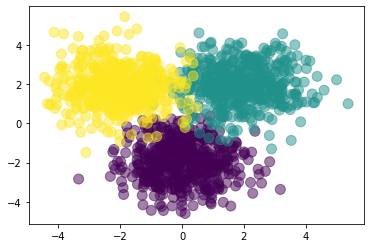

In [0]:
import numpy as np
import matplotlib.pyplot as plt

#generate random data
n = 500
D = 2 # dimensionality of input
M = 10 # hidden layer size
K = 3 # number of classes

X1 = np.random.randn(n, 2) + np.array([0, -2])
X2 = np.random.randn(n, 2) + np.array([2, 2])
X3 = np.random.randn(n, 2) + np.array([-2, 2])
X = np.vstack([X1, X2, X3])

Y = np.array([0]*n + [1]*n + [2]*n)

plt.scatter(X[:, 0], X[:, 1], c=Y, s=100, alpha=0.5)
plt.show()

N = len(Y)
Y_ind = np.zeros((N, K))
for i in range(N):
    Y_ind[i, Y[i]] = 1

Iteration  0 /50 Cost:  68.41652145172502  Error:  0.056666666666666664
Iteration  10 /50 Cost:  24.21160346597303  Error:  0.03
Iteration  20 /50 Cost:  18.789777996086872  Error:  0.023333333333333334
Iteration  30 /50 Cost:  18.54814403415835  Error:  0.02666666666666667
Iteration  40 /50 Cost:  19.534724555421516  Error:  0.023333333333333334
Iteration  50 /50 Cost:  18.384533934560746  Error:  0.02666666666666667


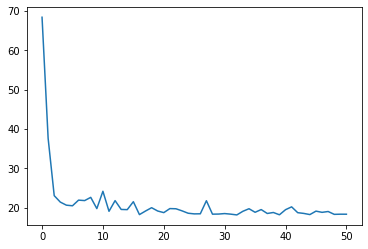

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import theano
import theano.tensor as T

def error_rate(p, t):
    return np.mean(p != t)

X, Y_ind = shuffle(X, Y_ind)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_ind, test_size=0.2)

reg = 0.01
lr = 0.05
batch_size = 250
eps = 10e-8
d = 0.99
n_batches = N//batch_size

W1_init = np.random.randn(D, M)/np.sqrt(M)
W2_init = np.random.randn(M, K)/np.sqrt(K)
b1_init = np.zeros(M)
b2_init = np.zeros(K)

thX = T.matrix('X')
thT = T.matrix('T')

W1 = theano.shared(W1_init)
W2 = theano.shared(W2_init)
b1 = theano.shared(b1_init)
b2 = theano.shared(b2_init)
cW1 = theano.shared(1)
cW2 = theano.shared(1)
cb1 = theano.shared(1)
cb2 = theano.shared(1)

thZ = T.nnet.relu(thX.dot(W1) + b1)
thY = T.nnet.softmax(thZ.dot(W2) + b2)

cost = -((thT * np.log(thY)).sum() + reg*((W1**2).sum() + (W2**2).sum() + (b1**2).sum() + (b2**2).sum()))
predictions = T.argmax(thY, axis=1)
targets = T.argmax(thT, axis=1)

gW1 = T.grad(cost, W1)
gW2 = T.grad(cost, W2)
gb1 = T.grad(cost, b1)
gb2 = T.grad(cost, b2)

cW1 = d*cW1 + (1-d)*(gW1**2)
cW2 = d*cW2 + (1-d)*(gW2**2)
cb1 = d*cb1 + (1-d)*(gb1**2)
cb2 = d*cb2 + (1-d)*(gb2**2)

update_W1 = W1 - lr*gW1/(T.sqrt(cW1) + eps)
update_W2 = W2 - lr*gW2/(T.sqrt(cW2) + eps)
update_b1 = b1 - lr*gb1/(T.sqrt(cb1) + eps)
update_b2 = b2 - lr*gb2/(T.sqrt(cb2) + eps)

train = theano.function(
    inputs=[thX, thT],
    updates=[(W1, update_W1), (W2, update_W2), (b1, update_b1), (b2, update_b2)]
)

get_predictions = theano.function(
    inputs=[thX, thT],
    outputs=[cost, predictions, targets]
)

costs = []
for i in range(51):
    for j in range(n_batches):
        X_batch = X_train[j*batch_size:(j*batch_size + batch_size),]
        Y_batch = Y_train[j*batch_size:(j*batch_size + batch_size),]

        train(X_batch, Y_batch)

    cost_val, preds, targets = get_predictions(X_test, Y_test)
    costs.append(cost_val)

    if i%10 == 0:
        print('Iteration ', i, '/50 Cost: ', cost_val, ' Error: ', error_rate(preds, targets))

plt.plot(costs)
plt.show()